In [1]:
import numpy as np 
import csv               
import cv2               
import os                
import sklearn           
from sklearn.model_selection import train_test_split    

from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Convolution2D, Cropping2D, Dropout
from keras.layers.pooling import MaxPooling2D
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


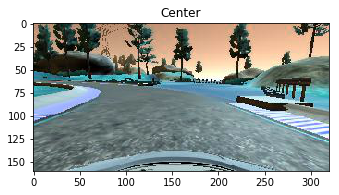

In [2]:
lines = []
with open('D:/Student Data/Desktop/iuuop/CarND-Behavioral-Cloning-P3-master/data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)
    for line in reader:
        lines.append(line)

imagesC = []
measurements = []
i = 0;
mylines = []
mylines.append(lines[1])
for line in mylines:
    source_path = line[0]
    filenameC = source_path.split('/')[-1]
    current_path = 'D:/Student Data/Desktop/iuuop/CarND-Behavioral-Cloning-P3-master/data/IMG/' + filenameC
    imageC = cv2.imread(current_path)
    imagesC.append(imageC)
   # measurement = float(line[3])
   # measurements.append(measurement)
    
imageC0 = imagesC[0]

plt.figure(figsize=(18,6))
plt.subplot(131)
plt.title('Center')
plt.imshow(imageC0)


In [3]:
def csvLines(imagepath):
    lines = []
    with open(imagepath + '/driving_log.csv') as f:
        reader = csv.reader(f)
        for line in reader:
            lines.append(line)
    return lines

def splitPath(dataPath, line):
    source_path = line
    filename = source_path.split('/')[-1]
    newLine = dataPath +'/IMG/'+filename.strip()
    return newLine

In [4]:
def getdata(imagepath):
    dirc = [x[0] for x in os.walk(imagepath)]
    data_dirc = list(filter(lambda x :os.path.isfile(x+'/driving_log.csv'), dirc))
    #print(data_dirc)
    
    center, left, right, angel = ([] for i in range(4))
    
    lines = csvLines(data_dirc[0])
    for line in lines:
        angel.append(float(line[3]))
        center.append(splitPath(imagepath,line[0]))
        left.append(splitPath(imagepath,line[1]))
        right.append(splitPath(imagepath,line[2]))
    
    return (center, left, right, angel)

In [5]:

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loops forever, generator never ends
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for imagePath, measurement in batch_samples:
                originalImage = cv2.imread(imagePath)
                image = cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)
                images.append(image)
                angles.append(measurement)
                # Data augment: Flipping images
                images.append(cv2.flip(image,1))
                #print(len(images))
                angles.append(measurement*-1.0)
                #print(len(angles))
            # Data augment: trim image to only see section with road
            inputs = np.array(images)
            outputs = np.array(angles)
            yield sklearn.utils.shuffle(inputs, outputs)

In [6]:
def buildNvidiaNetwork():
    
    model = Sequential()
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((70,25), (0,0))))
    model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(64,3,3, activation='relu'))
    model.add(Convolution2D(64,3,3, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))
    return model

In [7]:
# Reading images.
center, left, right, angel = getdata('D:/Student Data/Desktop/iuuop/CarND-Behavioral-Cloning-P3-master/data')
imagePaths, measurements = ([] for i in range(2))

imagePaths.extend(center)
imagePaths.extend(left)
imagePaths.extend(right)

measurements.extend(angel)
measurements.extend(x + 0.2 for x in angel)
measurements.extend(x - 0.2 for x in angel)

print('Total Images: {}'.format( len(imagePaths)))

Total Images: 24108


In [8]:
# Splitting samples into training and validation samples
samples = list(zip(imagePaths, measurements))
#print(samples)
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

print('Train samples: {}'.format(len(train_samples)))
print('Validation samples: {}'.format(len(validation_samples)))

# Creating train and validation generators.
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

Train samples: 19286
Validation samples: 4822


In [9]:
# Creating Model
model = buildNvidiaNetwork()

# Compiling and training the model
model.compile(loss='mse', optimizer='adam')
 
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 65, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 158, 24)   1824        cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 77, 36)    21636       convolution2d_1[0][0]            
___________________________________________________________________________________________

In [11]:
history = model.fit_generator(train_generator,
                              samples_per_epoch= len(train_samples),
                              validation_data=validation_generator, 
                              nb_val_samples=len(validation_samples), 
                              nb_epoch=2, verbose=1)

    
model.save('model.h5')

Epoch 1/2
19264/19286 [============================>.] - ETA: 0s - loss: 0.0192

C:\Users\Student\Miniconda3\envs\carnd-term1\lib\site-packages\keras\engine\training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


19328/19286 [==============================] - 578s - loss: 0.0191 - val_loss: 0.0173
Epoch 2/2
19308/19286 [==============================] - 557s - loss: 0.0178 - val_loss: 0.0177
